# Consumption layer

In [1]:
import re
import happybase
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import struct
import matplotlib.image as mpimg

### Defined functions

In [2]:
def connect_to_hbase(table_name):
    hbase_host = '10.186.0.20'
    connection = happybase.Connection(hbase_host, 9090)
    table = connection.table(table_name)
    return table,connection

In [3]:
def fetch_data_from_hbase(table,connection, table_name,start_row=None, end_row=None):
    data = []
    if table_name == 'stream_table':
        for key, value in table.scan(row_start=start_row, row_stop=end_row):
            row_data = {'row_key': key.decode()}
            for column_family, column_qualifiers in value.items():

                row_data[column_family] = column_qualifiers.decode()
            data.append(row_data)
    elif table_name == 'positions':
        for key, value in table.scan(row_start=start_row, row_stop=end_row):
            try: 
                row_data = {'row_key': key.decode}
                for column_family, column_qualifiers in value.items():
                    if column_family == b'position_cols:timestamp_utc':
                        row_data[column_family] = column_qualifiers
                    else:
                        row_data[column_family] = column_qualifiers.decode()
                data.append(row_data)
            except:
                continue
    else:
        for key, value in table.scan(row_start=start_row, row_stop=end_row):
            try: 
                row_data = {'row_key': key}
                for column_family, column_qualifiers in value.items():
                        row_data[column_family] = column_qualifiers.decode()
                data.append(row_data)
            except:
                continue
    connection.close()
    return data

In [4]:
def get_actual_weather(df):
    df[b'act_weather:act_timestamp_utc'] = pd.to_datetime(df[b'act_weather:act_timestamp_utc'], utc=True)
    df_sorted = df.sort_values(by=b'act_weather:act_timestamp_utc', ascending=False)

    newest_record = df_sorted.iloc[0]
    print('Current weather :')
    print(newest_record[b'act_weather:act_summary'])
    print('Temperature '+ newest_record[b'act_weather:act_temperature'])
    print('Cloud cover '+ newest_record[b'act_weather:act_cloud_cover'] + '%')
    print('Wind speed '+ newest_record[b'act_weather:act_speed'])
    print('Precipitation ' + newest_record[b'act_weather:act_precipitation_total'])
    return

In [5]:
def get_actual_delay(df):
    print(df[b'act_bus:bus_routeShortName'].unique())
    user_input = input('Which vehicle are you interested in : ')

    condition = df[b'act_bus:bus_routeShortName'] == user_input
    filtered_df = df[condition]
    
    df_sorted = filtered_df.sort_values(by=b'act_bus:bus_generated', ascending=False)
    newest_record = df_sorted.iloc[0]
    
    print('Current delay for line ' + user_input + " is " + newest_record[b'act_bus:bus_delay'] + ' seconds')
    

In [6]:
def get_predicted_delay(df):
    print(df[b'act_bus:bus_routeShortName'].unique())
    user_input = input('Which vehicle are you interested in : ')

    condition = df[b'act_bus:bus_routeShortName'] == user_input
    filtered_df = df[condition]
    
    df_sorted = filtered_df.sort_values(by=b'act_bus:bus_generated', ascending=False)
    newest_record = df_sorted.iloc[0]
    
    print('Predicted delay for the next 15 minute for line ' + user_input + " is " + newest_record[b'prediction:prediction'] + ' seconds')

In [7]:
def get_weather_forecast(df):
    df[b'act_weather:act_timestamp_utc'] = pd.to_datetime(df[b'act_weather:act_timestamp_utc'], utc=True)
    df_sorted = df.sort_values(by=b'act_weather:act_timestamp_utc', ascending=False)

    newest_record = df_sorted.iloc[0]
    print('Forecast weather :')
    print(newest_record[b'fc_weather:for_summary'])
    print('Temperature '+ newest_record[b'fc_weather:for_temperature'])
    print('Cloud cover '+ newest_record[b'fc_weather:for_cloud_cover'] + '%')
    print('Wind speed '+ newest_record[b'fc_weather:for_speed'])
    print('Precipitation ' + newest_record[b'fc_weather:for_precipitation_total'])
    return

In [8]:
def average_delay_by_route_plot(df):
    fig, ax = plt.subplots(figsize=(10, 20))
    df[b'position_cols:delay'] = [int(value) for value in df[b'position_cols:delay']]
    avg_delays = df.groupby([b'position_cols:routeShortName'])[b'position_cols:delay'].mean().reset_index().sort_values([b'position_cols:delay'])
    colors = []
    for route in avg_delays[b'position_cols:routeShortName']:
        if 'N' in route:
            colors.append('black')
        elif len(route) <= 2:
            colors.append('orange')
        else:
            colors.append('skyblue')

    bars = plt.barh(avg_delays[b'position_cols:routeShortName'], avg_delays[b'position_cols:delay'], color=colors)
    plt.title('Average delay by route from historical data')
    plt.show()
    return

In [9]:
def histogram_weather_plot(df):
    
    plt.figure(figsize=(10, 6))
    
    df['timestamp'] = df['row_key'].apply(lambda x: struct.unpack('>Q', x)[0])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    
    df[b'weather_cols:temperature'] = [float(value) for value in df[b'weather_cols:temperature']]
    plt.hist(df[b'weather_cols:temperature'], bins=5, color='skyblue', edgecolor='black')

    plt.title('Temperature Histogram for historical data')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')

In [10]:
def histogram_weather_last_5_hour_plot(df):
    
    plt.figure(figsize=(10, 6))
    
    
    df[b'act_bus:bus_generated'] = pd.to_datetime(df[b'act_bus:bus_generated'])
    df[b'act_bus:bus_generated'] = df[b'act_bus:bus_generated']+ pd.Timedelta(hours=1)
    
    
    filtered_df = df[df[b'act_bus:bus_generated'] >= df[b'act_bus:bus_generated'].max() - pd.Timedelta(hours=5)]
    
    filtered_df[b'act_weather:act_temperature'] = [float(value) for value in filtered_df[b'act_weather:act_temperature']]
    plt.hist(filtered_df[b'act_weather:act_temperature'], bins=5, color='skyblue', edgecolor='black')

    plt.title('Temperature Histogram from last 5h')
    plt.xlabel('Temperature (°C)')
    plt.ylabel('Frequency')

In [11]:
def plot_map(df, route, last_minutes=5):
    locations = df[df[b'act_bus:bus_routeShortName']==str(route)][[b'act_bus:bus_lat',b'act_bus:bus_lon',b'act_bus:bus_generated',b'act_bus:bus_vehicleId']]
    locations[b'act_bus:bus_generated'] = pd.to_datetime(locations[b'act_bus:bus_generated'])
    locations[b'act_bus:bus_generated'] = locations[b'act_bus:bus_generated']+ pd.Timedelta(hours=1)
    locations_5 = locations[locations[b'act_bus:bus_generated'] >= locations[b'act_bus:bus_generated'].max() - pd.Timedelta(minutes=5)]
    
    
    colors, labels = pd.factorize(locations_5[b'act_bus:bus_vehicleId'].astype(int))
    
    background_img = mpimg.imread('gdansk.png')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.imshow(background_img, extent=[locations[b'act_bus:bus_lon'].astype(float).min(), locations[b'act_bus:bus_lon'].astype(float).max(), locations[b'act_bus:bus_lat'].astype(float).min(), locations[b'act_bus:bus_lat'].astype(float).max()])
    ax.scatter(locations_5[b'act_bus:bus_lon'].astype(float),locations_5[b'act_bus:bus_lat'].astype(float),s=6,c=colors, cmap='viridis_r')
    plt.title('Example route')
    plt.show()

### Main user interface

In [12]:
table_streaming,connection = connect_to_hbase('stream_table')
data_streaming = fetch_data_from_hbase(table_streaming,connection,'stream_table')
df_streaming = pd.DataFrame(data_streaming)

In [13]:
table_positions_batch,connection = connect_to_hbase('positions')
data_positions_batch = fetch_data_from_hbase(table_positions_batch,connection,'positions')
df_positions_batch = pd.DataFrame(data_positions_batch)

In [14]:
table_weather_batch,connection = connect_to_hbase('weather')
data_weather_batch = fetch_data_from_hbase(table_weather_batch,connection,'weather')
df_weather_batch = pd.DataFrame(data_weather_batch)

In [15]:
get_actual_weather(df_streaming)

Current weather :
Overcast
Temperature 1.0
Cloud cover 97%
Wind speed 5.800000190734863
Precipitation 0.0


In [16]:
get_weather_forecast(df_streaming)

Forecast weather :
Overcast
Temperature 1.8
Cloud cover 91%
Wind speed 6.3
Precipitation 0.0


In [17]:
get_actual_delay(df_streaming)

['157' '12' '143' '199' '3' '2' '9' '8' '110' '112' '227' '148' '115'
 '168' '184' '175' '10' '155' '158' '154' '5' '127' '207' '117' '167' '6'
 '162' '171' '210' '108' '126' '256' '200' '205' '132' '174' '122' '130'
 '189' '179' '186' '111' '124' '106' '289' '120' '178' '136' '107' '208'
 '123' '149' '213' '169' '295' '100' '255' '249' '116' '138']


Which vehicle are you interested in :  12


Current delay for line 12 is -112 seconds


In [18]:
get_predicted_delay(df_streaming)

['157' '12' '143' '199' '3' '2' '9' '8' '110' '112' '227' '148' '115'
 '168' '184' '175' '10' '155' '158' '154' '5' '127' '207' '117' '167' '6'
 '162' '171' '210' '108' '126' '256' '200' '205' '132' '174' '122' '130'
 '189' '179' '186' '111' '124' '106' '289' '120' '178' '136' '107' '208'
 '123' '149' '213' '169' '295' '100' '255' '249' '116' '138']


Which vehicle are you interested in :  12


Predicted delay for the next 15 minute for line 12 is 293.0505803775053 seconds


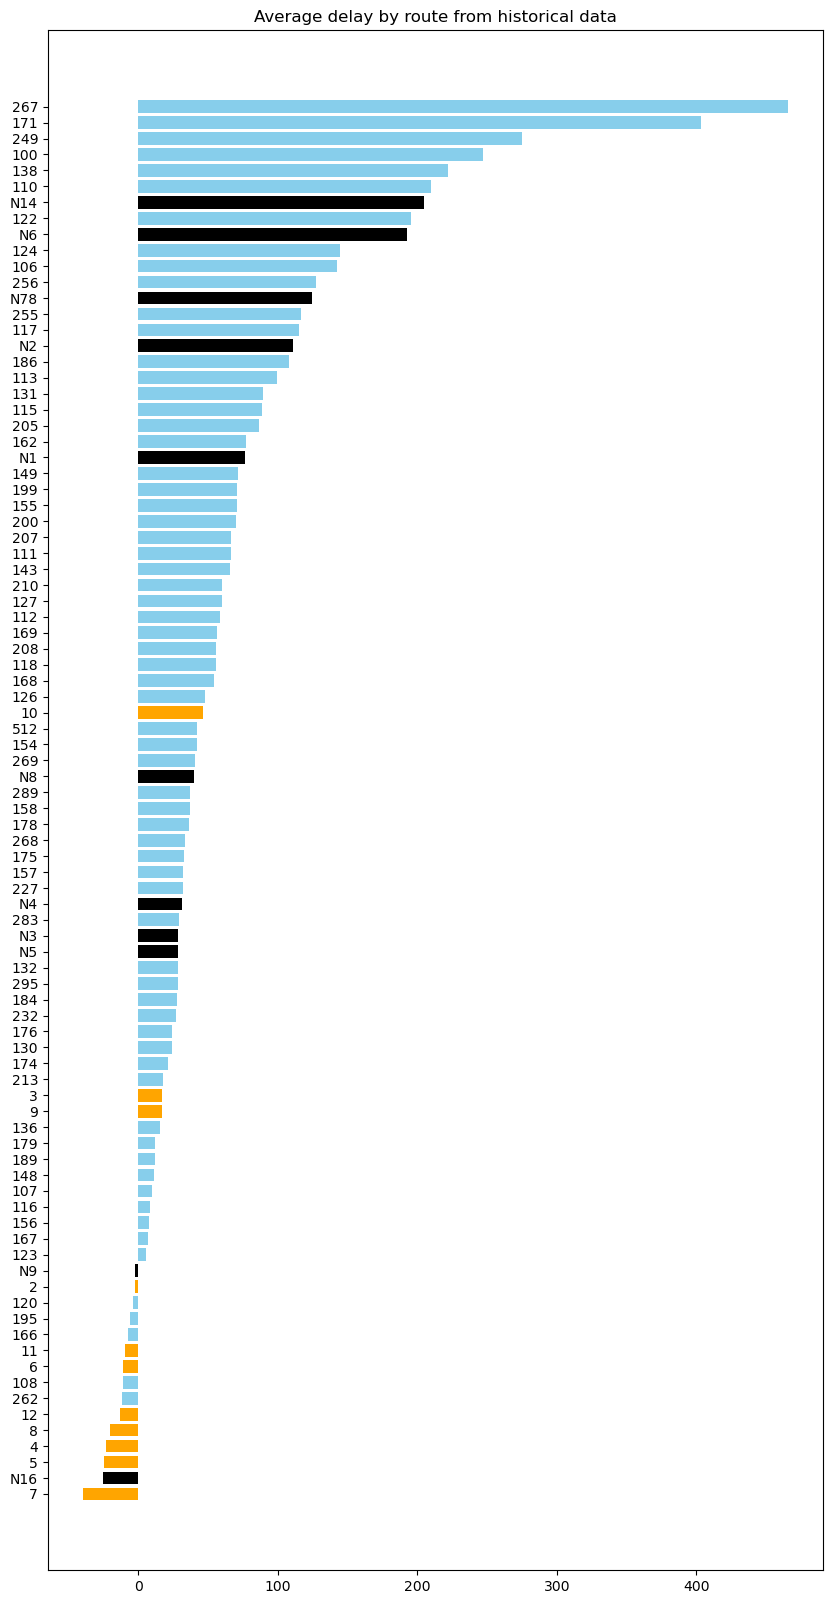

In [19]:
average_delay_by_route_plot(df_positions_batch)

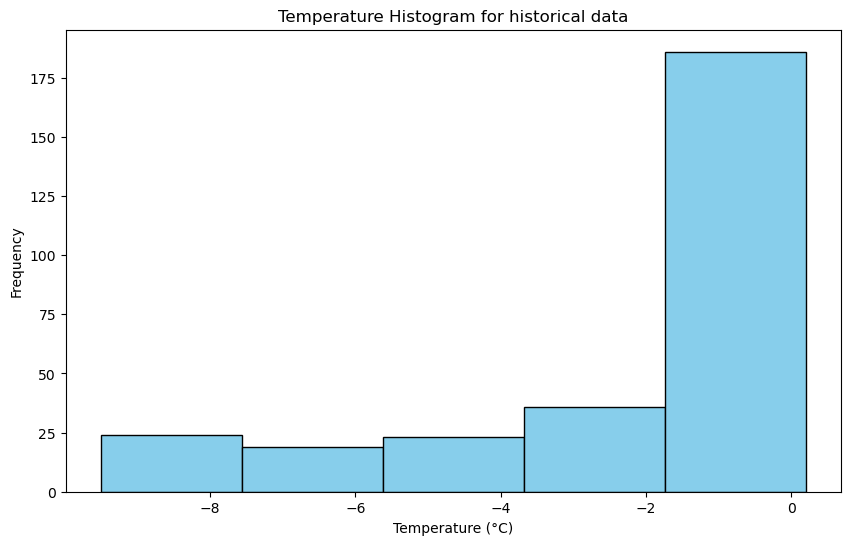

In [20]:
histogram_weather_plot(df_weather_batch)

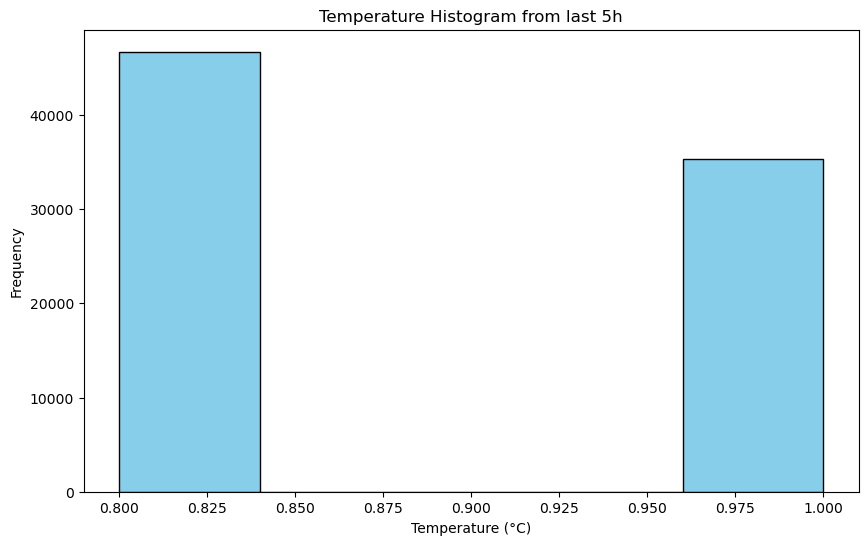

In [21]:
histogram_weather_last_5_hour_plot(df_streaming)

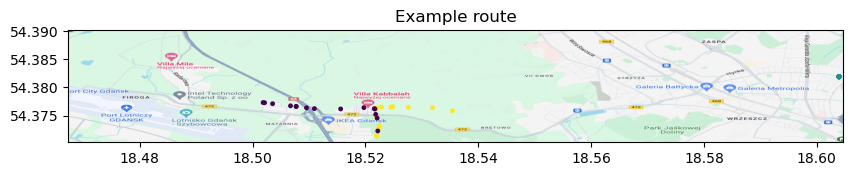

In [22]:
plot_map(df_streaming, route = 110)